In [40]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib 
import scipy 
import sklearn

from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
import seaborn as sns
import statsmodels.api

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5] 



In [41]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [42]:
def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [71]:
df = pd.read_csv('/Users/paul.carroll/Documents/datasets/history_export_2020-02-15T14_22_15.csv')
df['date'] = pd.to_datetime(df[['Day','Month','Year']])
df.set_index('date',inplace=True, drop=True)
df.head(2)

,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (low resolution) daily sum [sfc],Total Cloud Cover daily mean [sfc],...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],Wind Speed daily max [900 mb],Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


In [77]:
rename_map = {
   
    'Total Precipitation (low resolution) daily sum [sfc]':    'Rainfall',
    'Total Cloud Cover daily mean [sfc]':'Cloudcover',
   'Sunshine Duration daily sum [sfc]': 'Sunshine',
    'Temperature daily mean [2 m above gnd]':'Temperature',
    'Temperature daily max [2 m above gnd]':'Temperature_max',
    'Relative Humidity daily mean [2 m above gnd]':'Humidity',
    'Mean Sea Level Pressure daily mean [MSL]':'Pressure_mean',
    'Shortwave Radiation daily sum [sfc]':'Radiation',
     'Wind Speed daily max [900 mb]':'max_wind_speed',
    'Wind Speed daily mean [900 mb]':'Windspeed_mean'
}

df.rename(columns=rename_map, inplace=True)
df.head(2)

,Year,Month,Day,Hour,Minute,Temperature,Humidity,Pressure_mean,Rainfall,Cloudcover,...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],max_wind_speed,Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


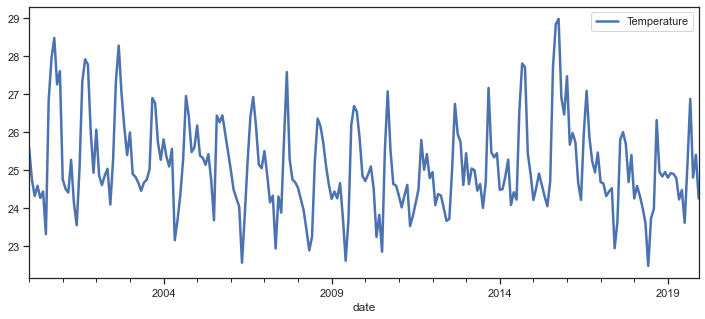

In [83]:
df.resample('M').mean()[['Temperature']].plot(lw=2.5,figsize=(12,5));

In [86]:
df= df.drop(['Hour','Minute'],axis=1)

In [102]:
check_stationarity(df.Temperature)

'Stationary	 p-value:1.7012041434276159e-12 	 lags:26


('Stationary', 1.7012041434276159e-12)

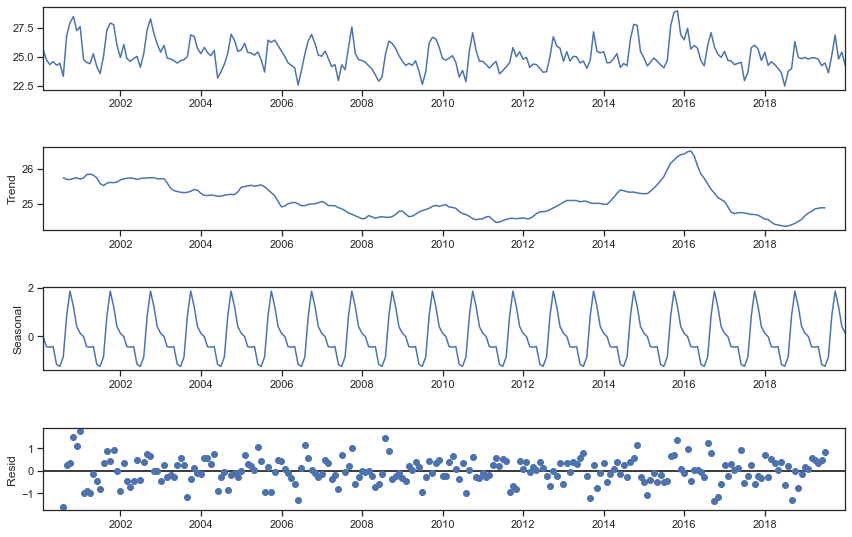

In [93]:
sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(df.resample('M').mean()[['Temperature']], period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();

In [97]:
#Differencing the milk dataset by 12, as from the seasonal_decompose the trend is annual. 
#milk_diff_12 = milk.diff(12).dropna()

In [98]:
#check_stationarity(milk_diff_12)
#however this is still not stationary.

In [100]:
#milk_diff_12_1= milk.diff(12).diff(1).dropna()
#check_stationarity(milk_diff_12_1)

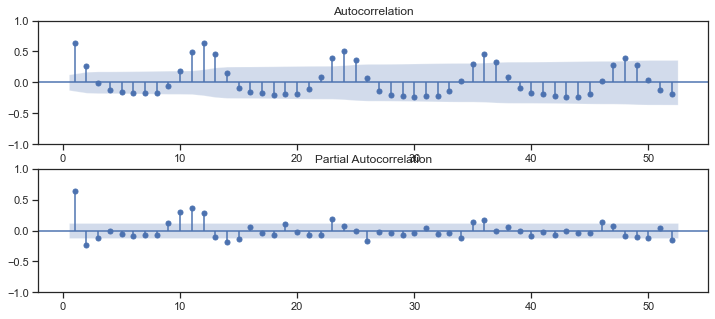

In [113]:
fig, ax= plt.subplots(2,1)
plot_acf(df.resample('M').mean()[['Temperature']], zero=False,
         ax=ax[0], lags=52)
plot_pacf(df.resample('M').mean()[['Temperature']],zero=False,
          ax=ax[1], lags=52)
plt.show();



In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#fitting a seasonal ARIMA model, SARIMAX, with p, d, q as 1,1,0 and 12 as S.
model = SARIMAX(df.Temperature, order =(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=False)



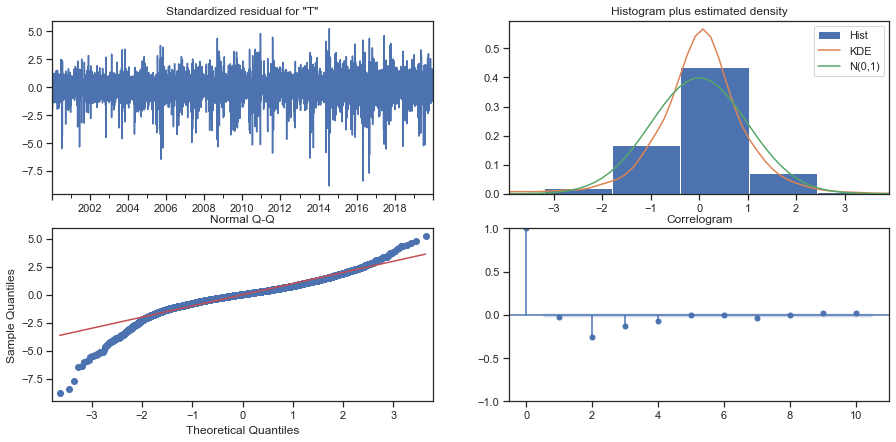

In [94]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [95]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                 7305
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -12642.670
Date:                            Thu, 15 Sep 2022   AIC                          25291.340
Time:                                    10:44:57   BIC                          25312.023
Sample:                                01-01-2000   HQIC                         25298.452
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0992      0.007     14.119      0.000       0.085       0.113
ma.S.L12      -0.9996      0.014    -69.061      0.000      -1.028      -0.971
sigma2         1.8580      0.029     64.719      0.000       1.802       1.914
===================================================================================
Ljung-Box (L1) (Q):                   4.11   Jarque-Bera (JB):             12923.91
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
from pmdarima.arima import auto_arima
import pmdarima as pm

In [116]:
train, test = pm.model_selection.train_test_split(df.Temperature,test_size=0.15)
print(f'Train: {train.size}')
print(f'Test: {test.shape}')

Train: 6209
Test: (1096,)


In [ ]:
auto_m = pm.auto_arima(train,
                       seasonal =True,
                       m = 12,
                       test = 'adf',
                       information_criterion = 'aic',
                       stepwise=True,
                       trace=True)
auto_m.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=8.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=26174.247, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=20703.111, Time=4.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=21789.418, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=57728.928, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=20657.694, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=20654.662, Time=2.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=6.23 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=20655.081, Time=4.36 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=14.35 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=25774.709, Time=0.67 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=20410.077, Time=2.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=20422.463, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.14 sec
 ARIMA(2,0,0)(0,0,2)[12] int

(4, 4)


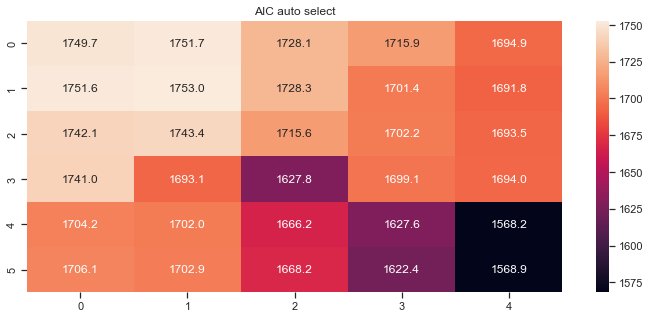

In [47]:
auto_select = sm.tsa.stattools.arma_order_select_ic(df.Temperature(), max_ar=5, max_ma=4, ic='aic', trend='n', model_kw={}, fit_kw={})

print(auto_select.aic_min_order)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.ylim([auto_select['aic'].shape[0], 0])
plt.title('AIC auto select')
plt.show()

In [51]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [54]:
test_split = 0.20
milk_train, milk_test = split_data(milk, test_split)

train: 134 , test: 34


In [66]:

P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(3))]*3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P,D,Q) in enumerate(vals):
    if i%15 ==0:
        #print(f'Running model #(i) using SARIMA({p},{d},{q})({P},{D},{Q},12)')
        m = SARIMAX(milk_train, order=(p,d,q),
                    seasonal_order = (P,D,Q,12),enforce_stationarity=False)
        res = m.fit(disp=0)
        y = milk_train.values.ravel()
        y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q), 'seasonal order':(P,D,Q),
                    'AIC':res.aic,
                    'RMSPE': rmspe(y, y_hat),
                    'BIC': res.bic,
                    'AICc':res.aicc,
                    'RMSE' : rmse(y, y_hat),
                    'MAPE' : mape(y, y_hat),
                    'model': res}

In [67]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score=v[c]
            best_model = k
            print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [68]:
best_model = get_best_model(score,'AIC')

Best model: 15 with lowest AIC score: 870.300019192765
Best model: 75 with lowest AIC score: 801.4011753396779
Best model: 105 with lowest AIC score: 664.5692312699438
Best model: 240 with lowest AIC score: 650.498342393047
Best model: 375 with lowest AIC score: 647.9802880338927
Best model: 510 with lowest AIC score: 647.4933298782302
Best model: 645 with lowest AIC score: 639.4116465947674


In [70]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,non-seasonal order,seasonal order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,654,"(2, 2, 0)","(0, 2, 0)",639.411647,10.015103,656.343531,640.90498,807.179782,0.773078,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,647,"(2, 1, 2)","(2, 2, 2)",639.411647,10.015103,656.343531,640.90498,807.179782,0.773078,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,648,"(2, 2, 0)","(0, 0, 0)",639.411647,10.015103,656.343531,640.90498,807.179782,0.773078,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,649,"(2, 2, 0)","(0, 0, 1)",639.411647,10.015103,656.343531,640.90498,807.179782,0.773078,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,650,"(2, 2, 0)","(0, 0, 2)",639.411647,10.015103,656.343531,640.90498,807.179782,0.773078,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
